# Stochastic Solver: Heterodyne Detection

Copyright (C) 2011 and later, Paul D. Nation & Robert J. Johansson

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from qutip import (Options, about, coherent, destroy, general_stochastic,
                   ket2dm, lindblad_dissipator, liouvillian, mesolve,
                   parallel_map, plot_expectation_values, smesolve, spost,
                   spre, stochastic_solvers)
from qutip.expect import expect_rho_vec

%matplotlib inline

## Introduction

Homodyne and hetrodyne detection are techniques for measuring the quadratures of a field using photocounters. Homodyne detection (on-resonant) measures one quadrature and with heterodyne detection (off-resonant) both quadratures can be detected simulateously.

The evolution of a quantum system that is coupled to a field that is monitored with homodyne and heterodyne detector can be described with stochastic master equations. This notebook compares two different ways to implement the heterodyne detection stochastic master equation in QuTiP.

## Deterministic reference

In [2]:
N = 15
w0 = 1.0 * 2 * np.pi
A = 0.1 * 2 * np.pi
times = np.linspace(0, 15, 201)
gamma = 0.25

ntraj = 50
nsubsteps = 50

a = destroy(N)
x = a + a.dag()
y = -1.0j * (a - a.dag())

H = w0 * a.dag() * a + A * (a + a.dag())

rho0 = coherent(N, np.sqrt(5.0), method="analytic")
c_ops = [np.sqrt(gamma) * a]
e_ops = [a.dag() * a, x, y]

In [3]:
result_ref = mesolve(H, rho0, times, c_ops, e_ops)

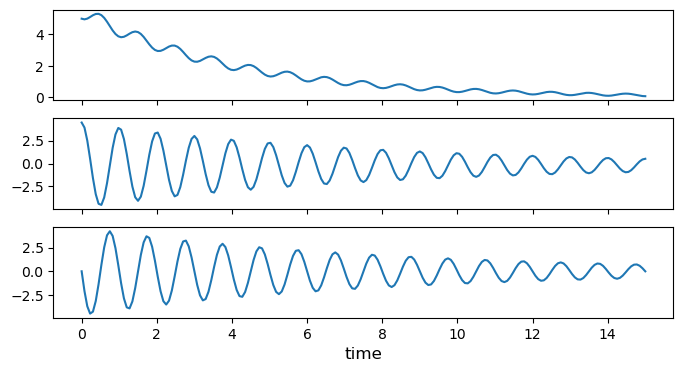

In [4]:
plot_expectation_values(result_ref);

## Heterodyne implementation #1

Stochastic master equation for heterodyne in Milburn's formulation

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_1(t) \sqrt{\gamma} \mathcal{H}[a] \rho(t) + \frac{1}{\sqrt{2}} dW_2(t) \sqrt{\gamma} \mathcal{H}[-ia] \rho(t)$

where $\mathcal{D}$ is the standard Lindblad dissipator superoperator, and $\mathcal{H}$ is defined as above,
and $dW_i(t)$ is a normal distributed increment with $E[dW_i(t)] = \sqrt{dt}$.


In QuTiP format we have:

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt +  D_{1}[A]\rho(t) dt + D_{2}^{(1)}[A]\rho(t) dW_1 + D_{2}^{(2)}[A]\rho(t) dW_2$

where $A = \sqrt{\gamma} a$, so we can identify

$\displaystyle D_{1}[A]\rho = \gamma \mathcal{D}[a]\rho = \mathcal{D}[A]\rho$

In [5]:
L = liouvillian(H)
D = lindblad_dissipator(c_ops[0])
d1_operator = L + D


def d1_rho_func(t, rho_vec):
    return d1_operator * rho_vec

$D_{2}^{(1)}[A]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[a] \rho =
\frac{1}{\sqrt{2}} \mathcal{H}[A] \rho =
\frac{1}{\sqrt{2}}(A\rho + \rho A^\dagger - \mathrm{Tr}[A\rho + \rho A^\dagger] \rho)
\rightarrow \frac{1}{\sqrt{2}} \left\{(A_L +  A_R^\dagger)\rho_v - \mathrm{Tr}[(A_L +  A_R^\dagger)\rho_v] \rho_v\right\}$

$D_{2}^{(2)}[A]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[-ia] \rho 
= \frac{1}{\sqrt{2}} \mathcal{H}[-iA] \rho =
\frac{-i}{\sqrt{2}}(A\rho - \rho A^\dagger - \mathrm{Tr}[A\rho - \rho A^\dagger] \rho)
\rightarrow \frac{-i}{\sqrt{2}} \left\{(A_L -  A_R^\dagger)\rho_v - \mathrm{Tr}[(A_L - A_R^\dagger)\rho_v] \rho_v\right\}$

In [6]:
B1 = spre(c_ops[0]) + spost(c_ops[0].dag())
B2 = spre(c_ops[0]) + spost(c_ops[0].dag())


def d2_rho_func(t, rho_vec):
    e1 = expect_rho_vec(B1.data, rho_vec, False)
    drho1 = B1 * rho_vec - e1 * rho_vec

    e1 = expect_rho_vec(B2.data, rho_vec, False)
    drho2 = B2 * rho_vec - e1 * rho_vec

    return np.vstack([1.0 / np.sqrt(2) * drho1, -1.0j / np.sqrt(2) * drho2])

The heterodyne currents for the $x$ and $y$ quadratures are

$J_x(t) = \sqrt{\gamma}\left<x\right> + \sqrt{2} \xi(t)$

$J_y(t) = \sqrt{\gamma}\left<y\right> + \sqrt{2} \xi(t)$

where $\xi(t) = \frac{dW}{dt}$.

In qutip we define these measurement operators using the `m_ops = [[x, y]]` and the coefficients to the noise terms `dW_factor = [sqrt(2/gamma), sqrt(2/gamma)]`.

In [7]:
result = general_stochastic(
    ket2dm(rho0),
    times,
    d1_rho_func,
    d2_rho_func,
    e_ops=[spre(op) for op in e_ops],
    len_d2=2,
    ntraj=ntraj,
    nsubsteps=nsubsteps,
    solver="platen",
    dW_factors=[np.sqrt(2 / gamma), np.sqrt(2 / gamma)],
    m_ops=[spre(x), spre(y)],
    store_measurement=True,
    map_func=parallel_map,
)

10.0%. Run time:   6.16s. Est. time left: 00:00:00:55


20.0%. Run time:   9.25s. Est. time left: 00:00:00:37


30.0%. Run time:  12.39s. Est. time left: 00:00:00:28


40.0%. Run time:  15.59s. Est. time left: 00:00:00:23


50.0%. Run time:  21.50s. Est. time left: 00:00:00:21


60.0%. Run time:  24.60s. Est. time left: 00:00:00:16


70.0%. Run time:  27.87s. Est. time left: 00:00:00:11


80.0%. Run time:  30.98s. Est. time left: 00:00:00:07


90.0%. Run time:  36.85s. Est. time left: 00:00:00:04


100.0%. Run time:  38.65s. Est. time left: 00:00:00:00


Total run time:  38.66s


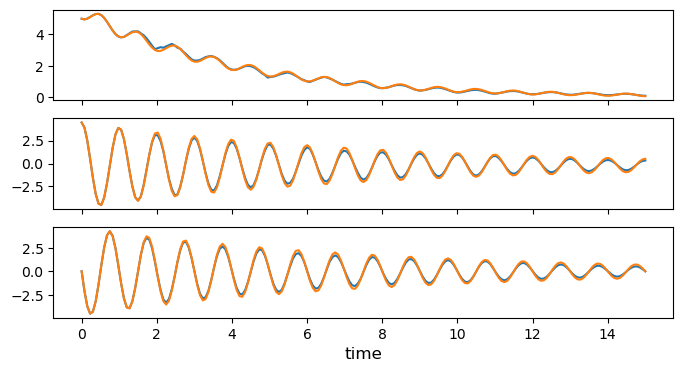

In [8]:
plot_expectation_values([result, result_ref]);

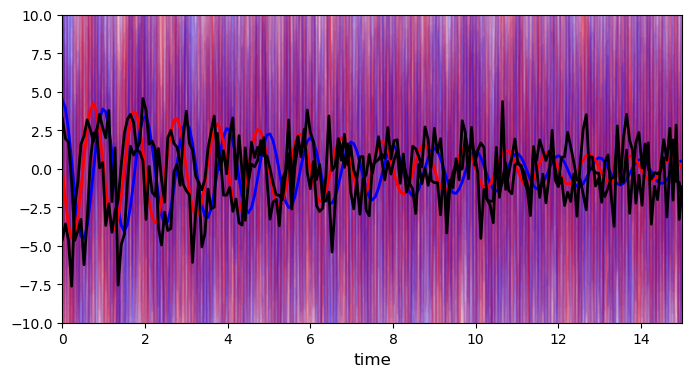

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))

for m in result.measurement:
    ax.plot(times, m[:, 0].real, "b", alpha=0.05)
    ax.plot(times, m[:, 1].real, "r", alpha=0.05)

ax.plot(times, result_ref.expect[1], "b", lw=2)
ax.plot(times, result_ref.expect[2], "r", lw=2)

ax.set_ylim(-10, 10)
ax.set_xlim(0, times.max())
ax.set_xlabel("time", fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:, 0].real, "k", lw=2)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:, 1].real, "k", lw=2);

## Heterodyne implementation #2: using two homodyne measurements


We can also write the heterodyne equation as

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \frac{1}{2}\gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_1(t) \sqrt{\gamma} \mathcal{H}[a] \rho(t) + \frac{1}{2}\gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_2(t) \sqrt{\gamma} \mathcal{H}[-ia] \rho(t)$


And using the QuTiP format for two stochastic collapse operators, we have:

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + D_{1}[A_1]\rho(t) dt + D_{2}[A_1]\rho(t) dW_1 + D_{1}[A_2]\rho(t) dt + D_{2}[A_2]\rho(t) dW_2$

so we can also identify

$\displaystyle D_{1}[A_1]\rho = \frac{1}{2}\gamma \mathcal{D}[a]\rho = \mathcal{D}[\sqrt{\gamma}a/\sqrt{2}]\rho = \mathcal{D}[A_1]\rho$

$\displaystyle D_{1}[A_2]\rho = \frac{1}{2}\gamma \mathcal{D}[a]\rho = \mathcal{D}[-i\sqrt{\gamma}a/\sqrt{2}]\rho = \mathcal{D}[A_2]\rho$


$D_{2}[A_1]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[a] \rho = \mathcal{H}[A_1] \rho$

$D_{2}[A_2]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[-ia] \rho  = \mathcal{H}[A_2] \rho $

where $A_1 = \sqrt{\gamma} a / \sqrt{2}$ and $A_2 = -i \sqrt{\gamma} a / \sqrt{2}$.

In summary we have

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \sum_i\left\{\mathcal{D}[A_i]\rho(t) dt + \mathcal{H}[A_i]\rho(t) dW_i\right\}$

which is a simultaneous homodyne detection with $A_1 = \sqrt{\gamma}a/\sqrt{2}$ and $A_2 = -i\sqrt{\gamma}a/\sqrt{2}$

Here the two heterodyne currents for the $x$ and $y$ quadratures are

$J_x(t) = \sqrt{\gamma/2}\left<x\right> + \xi(t)$

$J_y(t) = \sqrt{\gamma/2}\left<y\right> + \xi(t)$

where $\xi(t) = \frac{dW}{dt}$.

In qutip we can use the predefined homodyne solver for solving this problem.

In [10]:
opt = Options()
opt.store_states = True
result = smesolve(
    H,
    rho0,
    times,
    [],
    [np.sqrt(gamma / 2) * a, -1.0j * np.sqrt(gamma / 2) * a],
    e_ops,
    ntraj=100,
    nsubsteps=nsubsteps,
    solver="taylor15",
    m_ops=[x, y],
    dW_factors=[np.sqrt(2 / gamma), np.sqrt(2 / gamma)],
    method="homodyne",
    store_measurement=True,
    map_func=parallel_map,
)

10.0%. Run time:   2.04s. Est. time left: 00:00:00:18


20.0%. Run time:   3.40s. Est. time left: 00:00:00:13


30.0%. Run time:   5.40s. Est. time left: 00:00:00:12


40.0%. Run time:   6.76s. Est. time left: 00:00:00:10


50.0%. Run time:   8.77s. Est. time left: 00:00:00:08


60.0%. Run time:  10.14s. Est. time left: 00:00:00:06


70.0%. Run time:  12.12s. Est. time left: 00:00:00:05


80.0%. Run time:  13.51s. Est. time left: 00:00:00:03


90.0%. Run time:  15.49s. Est. time left: 00:00:00:01


100.0%. Run time:  16.85s. Est. time left: 00:00:00:00


Total run time:  16.86s


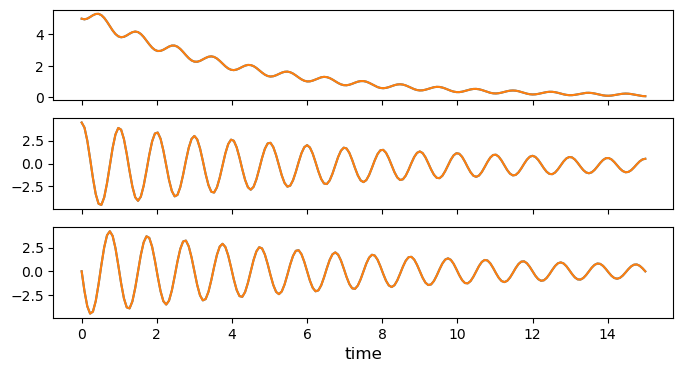

In [11]:
plot_expectation_values([result, result_ref]);

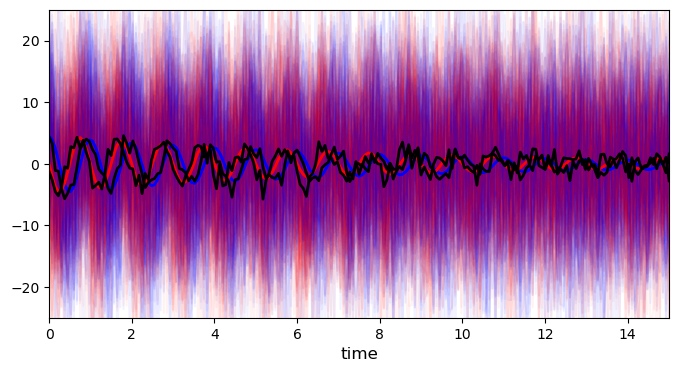

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))

for m in result.measurement:
    ax.plot(times, m[:, 0].real, "b", alpha=0.05)
    ax.plot(times, m[:, 1].real, "r", alpha=0.05)

ax.plot(times, result_ref.expect[1], "b", lw=2)
ax.plot(times, result_ref.expect[2], "r", lw=2)

ax.set_xlim(0, times.max())
ax.set_ylim(-25, 25)
ax.set_xlabel("time", fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:, 0].real, "k", lw=2)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:, 1].real, "k", lw=2);

## Implementation #3: builtin function for heterodyne

In [13]:
result = smesolve(
    H,
    rho0,
    times,
    [],
    [np.sqrt(gamma) * a],
    e_ops,
    ntraj=ntraj,
    nsubsteps=nsubsteps,
    solver="taylor15",
    method="heterodyne",
    store_measurement=True,
    map_func=parallel_map,
)

10.0%. Run time:   1.56s. Est. time left: 00:00:00:14


20.0%. Run time:   2.24s. Est. time left: 00:00:00:08


30.0%. Run time:   2.92s. Est. time left: 00:00:00:06


40.0%. Run time:   3.59s. Est. time left: 00:00:00:05


50.0%. Run time:   4.92s. Est. time left: 00:00:00:04


60.0%. Run time:   5.60s. Est. time left: 00:00:00:03


70.0%. Run time:   6.30s. Est. time left: 00:00:00:02


80.0%. Run time:   7.06s. Est. time left: 00:00:00:01


90.0%. Run time:   8.30s. Est. time left: 00:00:00:00


100.0%. Run time:   8.71s. Est. time left: 00:00:00:00


Total run time:   8.72s


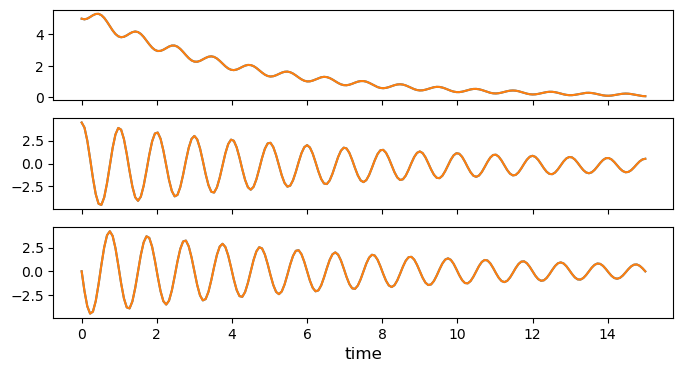

In [14]:
plot_expectation_values([result, result_ref]);

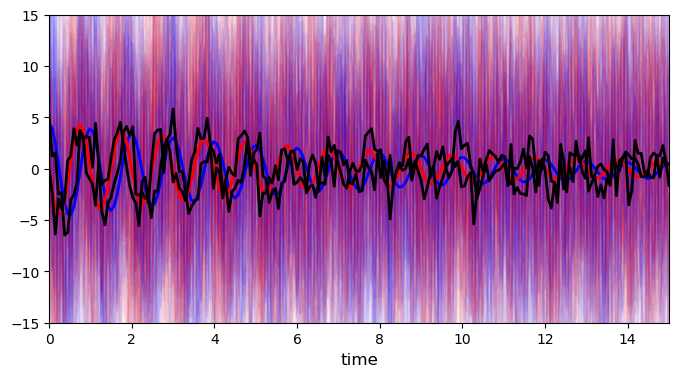

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))

for m in result.measurement:
    ax.plot(times, m[:, 0, 0].real / np.sqrt(gamma), "b", alpha=0.05)
    ax.plot(times, m[:, 0, 1].real / np.sqrt(gamma), "r", alpha=0.05)

ax.plot(times, result_ref.expect[1], "b", lw=2)
ax.plot(times, result_ref.expect[2], "r", lw=2)

ax.set_xlim(0, times.max())
ax.set_ylim(-15, 15)
ax.set_xlabel("time", fontsize=12)
ax.plot(
    times,
    np.array(result.measurement).mean(axis=0)[:, 0, 0].real / np.sqrt(gamma),
    "k",
    lw=2,
)
ax.plot(
    times,
    np.array(result.measurement).mean(axis=0)[:, 0, 1].real / np.sqrt(gamma),
    "k",
    lw=2,
);

## Common problem

For some systems, the resulting density matrix can become unphysical due to the accumulation of computation error.

In [16]:
N = 5
w0 = 1.0 * 2 * np.pi
A = 0.1 * 2 * np.pi
times = np.linspace(0, 15, 301)
gamma = 0.25

ntraj = 150
nsubsteps = 50

a = destroy(N)
x = a + a.dag()
y = -1.0j * (a - a.dag())

H = w0 * a.dag() * a + A * (a + a.dag())

rho0 = coherent(N, np.sqrt(5.0), method="analytic")
c_ops = [np.sqrt(gamma) * a]
e_ops = [a.dag() * a, x, y]

opt = Options()
opt.store_states = True
result = smesolve(
    H,
    rho0,
    times,
    [],
    [np.sqrt(gamma) * a],
    e_ops,
    ntraj=1,
    nsubsteps=5,
    solver="euler",
    method="heterodyne",
    store_measurement=True,
    map_func=parallel_map,
    options=opt,
    normalize=False,
)

Total run time:   0.06s


In [17]:
result.states[0][100].full()

array([[ 1.22284878e+00+1.02550964e-14j,  1.96058916e-01+3.58844428e+00j,
        -1.36561265e+01+4.93444019e+00j, -1.68286542e+01-3.53124020e+01j,
         5.83071620e+01-2.39685041e+01j],
       [ 1.96058916e-01-3.58844428e+00j, -4.66017980e-02-2.02689339e-14j,
         1.35912671e+00-5.00137944e-01j,  1.62838620e+00+3.53410309e+00j,
        -5.84417341e+00+2.30541937e+00j],
       [-1.36561265e+01-4.93444019e+00j,  1.35912671e+00+5.00137944e-01j,
        -1.91017905e-01+6.51865754e-15j, -1.05795175e-01-2.48167176e-01j,
         4.13901266e-01-1.56598118e-01j],
       [-1.68286542e+01+3.53124020e+01j,  1.62838620e+00-3.53410309e+00j,
        -1.05795175e-01+2.48167176e-01j,  1.23964976e-02+3.49217640e-15j,
        -2.42557679e-02+9.37329722e-03j],
       [ 5.83071620e+01+2.39685041e+01j, -5.84417341e+00-2.30541937e+00j,
         4.13901266e-01+1.56598118e-01j, -2.42557679e-02-9.37329722e-03j,
         2.37300393e-03+9.06266670e-18j]])

In [18]:
sp.linalg.eigh(result.states[0][10].full())

(array([-1.95507587e-01, -1.49575022e-03, -1.23800605e-04,  1.93827987e-02,
         6.75291092e-01]),
 array([[ 0.4667251 +0.j        ,  0.5001959 +0.j        ,
         -0.33256147-0.j        , -0.59854816-0.j        ,
          0.2512264 -0.j        ],
        [-0.47414406-0.07427356j,  0.31131599+0.10382324j,
         -0.70663333-0.13022909j,  0.13917263+0.08974664j,
         -0.34280455-0.02729854j],
        [ 0.30234706+0.11135691j, -0.45273953-0.26976623j,
         -0.54164695-0.23498638j,  0.32720244+0.00477564j,
          0.40227066+0.03054587j],
        [-0.02775986-0.07647214j, -0.39537555-0.43669283j,
         -0.0986564 -0.12003064j, -0.50087146-0.36795979j,
         -0.48515426-0.02402532j],
        [-0.66152477-0.06156945j, -0.05605955-0.11914326j,
          0.01801029-0.00691084j, -0.30219084-0.17218141j,
          0.64445749-0.0677722j ]]))

Using smaller integration steps by increasing the nsubstep will lower the numerical errors.  
The solver algorithm used affect the convergence and numerical error.
Notable solvers are:  
- euler: order 0.5 fastest, but lowest order. Only solver that accept non-commuting sc_ops
- rouchon: order 1.0?, build to keep the density matrix physical
- taylor1.5: order 1.5, default solver, reasonably fast for good convergence.
- taylor2.0: order 2.0, even better convergence but can only take 1 homodyne sc_ops.


To list list all available solver, use help(stochastic_solvers)

In [19]:
help(stochastic_solvers)

Help on function stochastic_solvers in module qutip.stochastic:

stochastic_solvers()
    This function is purely a reference point for documenting the available
    stochastic solver methods, and takes no actions.
    
    Notes
    -----
    Available solvers for :obj:`~ssesolve` and :obj:`~smesolve`
        euler-maruyama
            A simple generalization of the Euler method for ordinary
            differential equations to stochastic differential equations.  Only
            solver which could take non-commuting ``sc_ops``. *not tested*
    
            - Order 0.5
            - Code: ``'euler-maruyama'``, ``'euler'`` or ``0.5``
    
        milstein
            An order 1.0 strong Taylor scheme.  Better approximate numerical
            solution to stochastic differential equations.  See eq. (2.9) of
            chapter 12.2 of [1]_.
    
            - Order strong 1.0
            - Code: ``'milstein'`` or ``1.0``
    
        milstein-imp
            An order 1.0 implicit stro

## About

In [20]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.6
Numpy Version:      1.26.4
Scipy Version:      1.12.0
Cython Version:     0.29.37
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v4/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex refer